In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit
import Peak_Wavelength_Extractor as PWE

import importlib

import Calibration_Function_V2 as CF2
import Calibration_Function as CF

importlib.reload(CF2)
importlib.reload(CF)
importlib.reload(PWE)

<module 'Peak_Wavelength_Extractor' from 'C:\\Users\\sebas\\PycharmProjects\\Advanced-Lab-Code\\Intensity_Runs_293K\\Peak_Wavelength_Extractor.py'>

# Data Processing

In [2]:
#Note: we have swapped to a different monochromator as there were issues with the original
wavelengths = np.array([692.7])

start_indexes = [9795]

sheets = ['Peak']

cols = [['R_0','R_1','R_2','R_3']]
file = "Peak_intensity_data.xlsx"

In [3]:
def chi_squared(model, model_params, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params)) / y_error) ** 2)


def reduced_chi_squared(Chi_squared, DoF):
    return Chi_squared / (DoF)

def wavelength_extraction(x,start_index):
    A = 1.0095
    alpha_A = 0.0001

    B = 9091.0570
    alpha_B = 0.0289

    wavelength = (start_index-x/10-B)/A

    uncertainty = np.abs((x-(B+alpha_B))/(A+alpha_A) - wavelength)

    print(wavelength)
    return wavelength, uncertainty

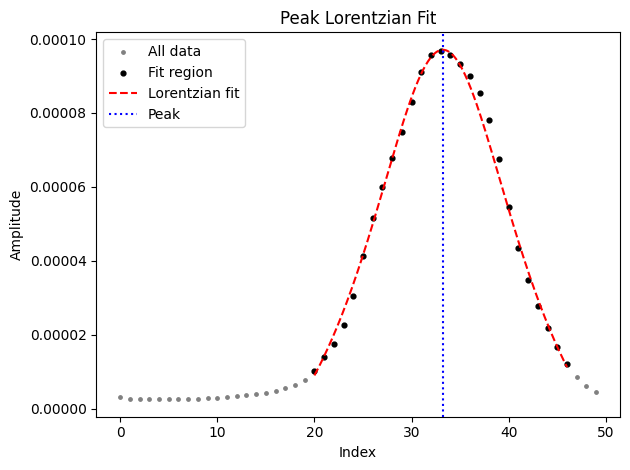

 ---- Results ---- 
Sheet: Peak
Peak index = 33.222 ± 0.104
Width B = 10.12
Reduced χ² = 0.261
Amplitude cutoff = 10.0% of A_max
----- ----- -----

The Peak wavelengths are: [array([694.02758488])] ± [array([0.09736803])]


In [4]:
wavelengths, wavelength_errs, peaks, peak_errs = PWE.Peak_Wavelength(
    file= file,
    sheets=sheets,
    cols=cols,
    start_index=start_indexes,
    amplitude_frac=0.1,
    min_points=25,
    max_width=200
)

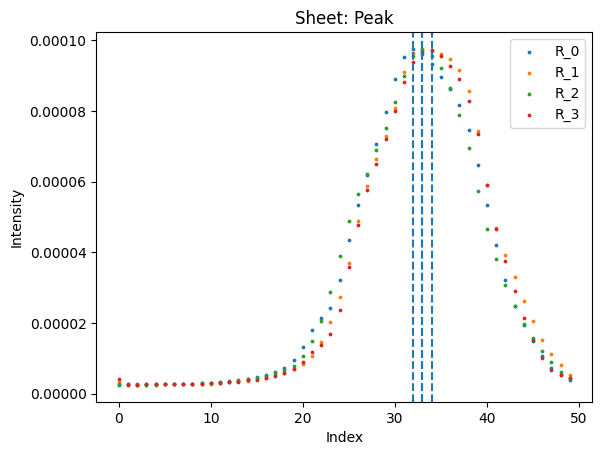

----- Results -----
Sheet 'Peak': mean peak index = 33.0 ± 0.3535533905932738
Standard deviation of the mean is 0.7071067811865476
----- ----- -----


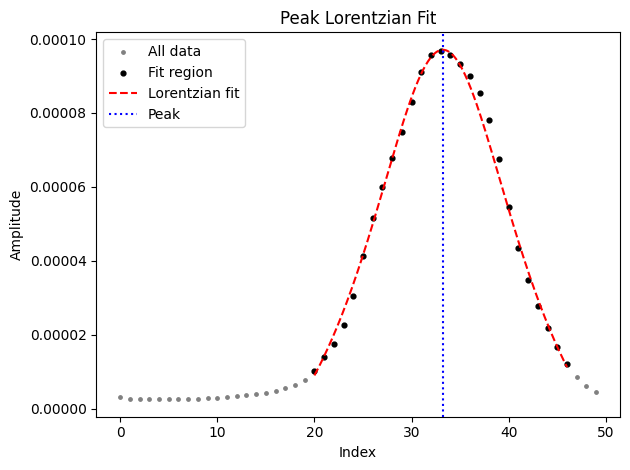

 ---- Results ---- 
Sheet: Peak
Peak index = 33.222 ± 0.104
Width B = 10.12
Reduced χ² = 0.261
Amplitude cutoff = 9.0% of A_max
----- ----- -----



In [5]:
CF.Calibration_Index(file_name=file, sheet_names=sheets, column_names=cols)
# Peak Extraction
# all at once (if the noise is acceptable)
results, res_err = CF2.peak_extractor(
    file=file,
    sheets=sheets,
    cols=cols,
    amplitude_frac=0.09,
    uncertainty_frac=1e-3,
    min_points=15,
    min_width=5,
    max_width=300
)

In [6]:
np.abs(692.7-wavelength_extraction(33.222,9795)[0])

694.0275383853381


np.float64(1.3275383853380163)

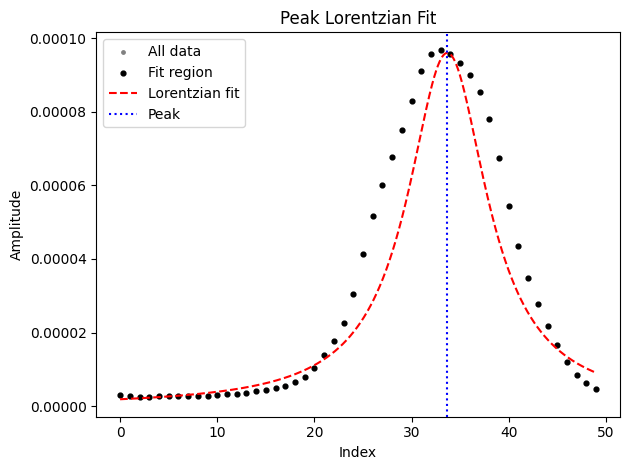

 ---- Results ---- 
Sheet: Peak
Peak index = 33.679 ± 0.087
Width B = 5.00
Reduced χ² = 40.689
Amplitude cutoff = 1.0% of A_max
----- ----- -----



IndexError: list index out of range

In [7]:
#individually (if noise is unacceptable)

results_red, red_err = CF2.peak_extractor(
    file=file,
    sheets=sheets[0],
    cols=cols[0],
    amplitude_frac=0.01,
    uncertainty_frac=1e-3,
    min_points=15,
    min_width=5,
    max_width=300
)

results_orange, orange_err = CF2.peak_extractor(
    file=file,
    sheets=sheets[1],
    cols=cols[1],
    amplitude_frac=0.05,
    uncertainty_frac=1e-3,
    min_points=15,
    min_width=5,
    max_width=300
)

results_green, green_err = CF2.peak_extractor(
    file=file,
    sheets=sheets[2],
    cols=cols[2],
    amplitude_frac=0.01,
    uncertainty_frac=1e-3,
    min_points=15,
    min_width=5,
    max_width=300
)
# Model Fitting
results = np.concatenate((results_red, results_orange, results_green))
results_err = np.concatenate((red_err, orange_err, green_err))


def line(x, A, B):
    return x * A + B


p0_line = [1, 1]

indexes = start_indexes - 0.1 * results
indexes_error = np.abs((start_indexes - 0.1 * (results + results_err)) - (start_indexes - 0.1 * results))

print(results_err)
print(indexes_error)

popt_line, cov_line = curve_fit(line,
                                xdata=wavelengths,
                                ydata=indexes,
                                sigma=indexes_error,
                                absolute_sigma=True,
                                p0=p0_line)

dof_line = len(wavelengths) - len(popt_line)

chi2 = chi_squared(model=line,
                   model_params=popt_line,
                   x_data=wavelengths,
                   y_data=indexes,
                   y_error=indexes_error
                   )

Rchi2 = reduced_chi_squared(chi2, DoF=dof_line)

plt.figure(1)

plt.scatter(wavelengths, indexes, marker="D", color='black', s=4)
plt.plot(wavelengths, line(wavelengths, popt_line[0], popt_line[1]), color="grey", linestyle="--", alpha=0.5)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Indexes")
plt.show()

print(f"----- Results -----")
print(f"Gradient is {popt_line[0]:.4f} ± {np.sqrt(cov_line[0, 0]):.4f}")
print(f"Intercept is {popt_line[1]:.4f} ± {np.sqrt(cov_line[1, 1]):.4f}")
print(f"Reduced chi_squared is {Rchi2:.4f}")
print("----- ----- -----")
print(indexes)

In [8]:
(9786-9091)/1.0095

688.4596334819217